In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.8 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedakram1","key":"66701960f6726013c71587d887b8253a"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sshikamaru/car-object-detection

Dataset URL: https://www.kaggle.com/datasets/sshikamaru/car-object-detection
License(s): other
  0% 0.00/112M [00:00<?, ?B/s]
100% 112M/112M [00:00<00:00, 1.39GB/s]


In [5]:
!unzip /content/car-object-detection.zip

Archive:  /content/car-object-detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/testing_images/vid_5_25100.jpg  
  inflating: data/testing_images/vid_5_25120.jpg  
  inflating: data/testing_images/vid_5_25140.jpg  
  inflating: data/testing_images/vid_5_25160.jpg  
  inflating: data/testing_images/vid_5_25180.jpg  
  inflating: data/testing_images/vid_5_25200.jpg  
  inflating: data/testing_images/vid_5_25220.jpg  
  inflating: data/testing_images/vid_5_25240.jpg  
  inflating: data/testing_images/vid_5_25260.jpg  
  inflating: data/testing_images/vid_5_26320.jpg  
  inflating: data/testing_images/vid_5_26400.jpg  
  inflating: data/testing_images/vid_5_26420.jpg  
  inflating: data/testing_images/vid_5_26560.jpg  
  inflating: data/testing_images/vid_5_26580.jpg  
  inflating: data/testing_images/vid_5_26600.jpg  
  inflating: data/testing_images/vid_5_26620.jpg  
  inflating: data/testing_images/vid_5_26640.jpg  
  inflating: data/testing_images/vid_5_26660.jp

In [6]:
from ultralytics import YOLO
model = YOLO("yolov8m.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
import os
import shutil

base_path = '/content/data'
images_path = os.path.join(base_path, 'images')
labels_path = os.path.join(base_path, 'labels')

os.makedirs(os.path.join(images_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(images_path, 'val'), exist_ok=True)
os.makedirs(os.path.join(labels_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(labels_path, 'val'), exist_ok=True)

print("Folder structure created!")


Folder structure created!


In [8]:
import glob
import random

train_ratio = 0.8
all_images = glob.glob(os.path.join(base_path, 'training_images', '*.jpg'))
random.shuffle(all_images)
split_idx = int(len(all_images) * train_ratio)

train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

# Move images
for img in train_images:
    shutil.copy(img, os.path.join(images_path, 'train'))
for img in val_images:
    shutil.copy(img, os.path.join(images_path, 'val'))

print(f"Training images: {len(train_images)}, Validation images: {len(val_images)}")


Training images: 800, Validation images: 201


In [9]:
import pandas as pd

csv_path = '/content/data/train_solution_bounding_boxes (1).csv'
df = pd.read_csv(csv_path)

print(df.head())
print(df.columns)


             image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
Index(['image', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')


In [10]:
import pandas as pd
import cv2

csv_path = os.path.join(base_path, '/content/data/train_solution_bounding_boxes (1).csv')
df = pd.read_csv(csv_path)

class_map = {'car': 0}

def convert_to_yolo(row, img_width, img_height):
    # Calculate width & height
    w = row['xmax'] - row['xmin']
    h = row['ymax'] - row['ymin']

    # Calculate center
    x_center = (row['xmin'] + w/2) / img_width
    y_center = (row['ymin'] + h/2) / img_height

    # Normalize width & height
    w_norm = w / img_width
    h_norm = h / img_height

    class_id = 0
    return f"{class_id} {x_center} {y_center} {w_norm} {h_norm}"


# Process images
for split, image_list in zip(['train', 'val'], [train_images, val_images]):
    for img_path in image_list:
        img_name = os.path.basename(img_path)
        # Open image to get size
        img = cv2.imread(img_path)
        h, w, _ = img.shape

        # Get all rows for this image
        boxes = df[df['image'] == img_name]
        if len(boxes) == 0:
            continue  # no objects

        # Convert each box
        yolo_lines = [convert_to_yolo(row, w, h) for _, row in boxes.iterrows()]

        # Save label file
        label_file = os.path.join(labels_path, split, img_name.replace('.jpg', '.txt'))
        with open(label_file, 'w') as f:
            f.write('\n'.join(yolo_lines))


In [11]:
yaml_content = f"""
train: {os.path.join(images_path, 'train')}
val: {os.path.join(images_path, 'val')}

nc: 1
names: ['car']
"""

yaml_path = os.path.join(base_path, 'car_dataset.yaml')
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print("YAML file created at", yaml_path)


YAML file created at /content/data/car_dataset.yaml


In [12]:
from ultralytics import YOLO

# Load YOLOv8 medium model
model = YOLO("yolov8m.pt")

# Train
model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=8,
    name='car_detection_colab',
    device=0
)


Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/car_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=car_detection_colab, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x785f405271d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

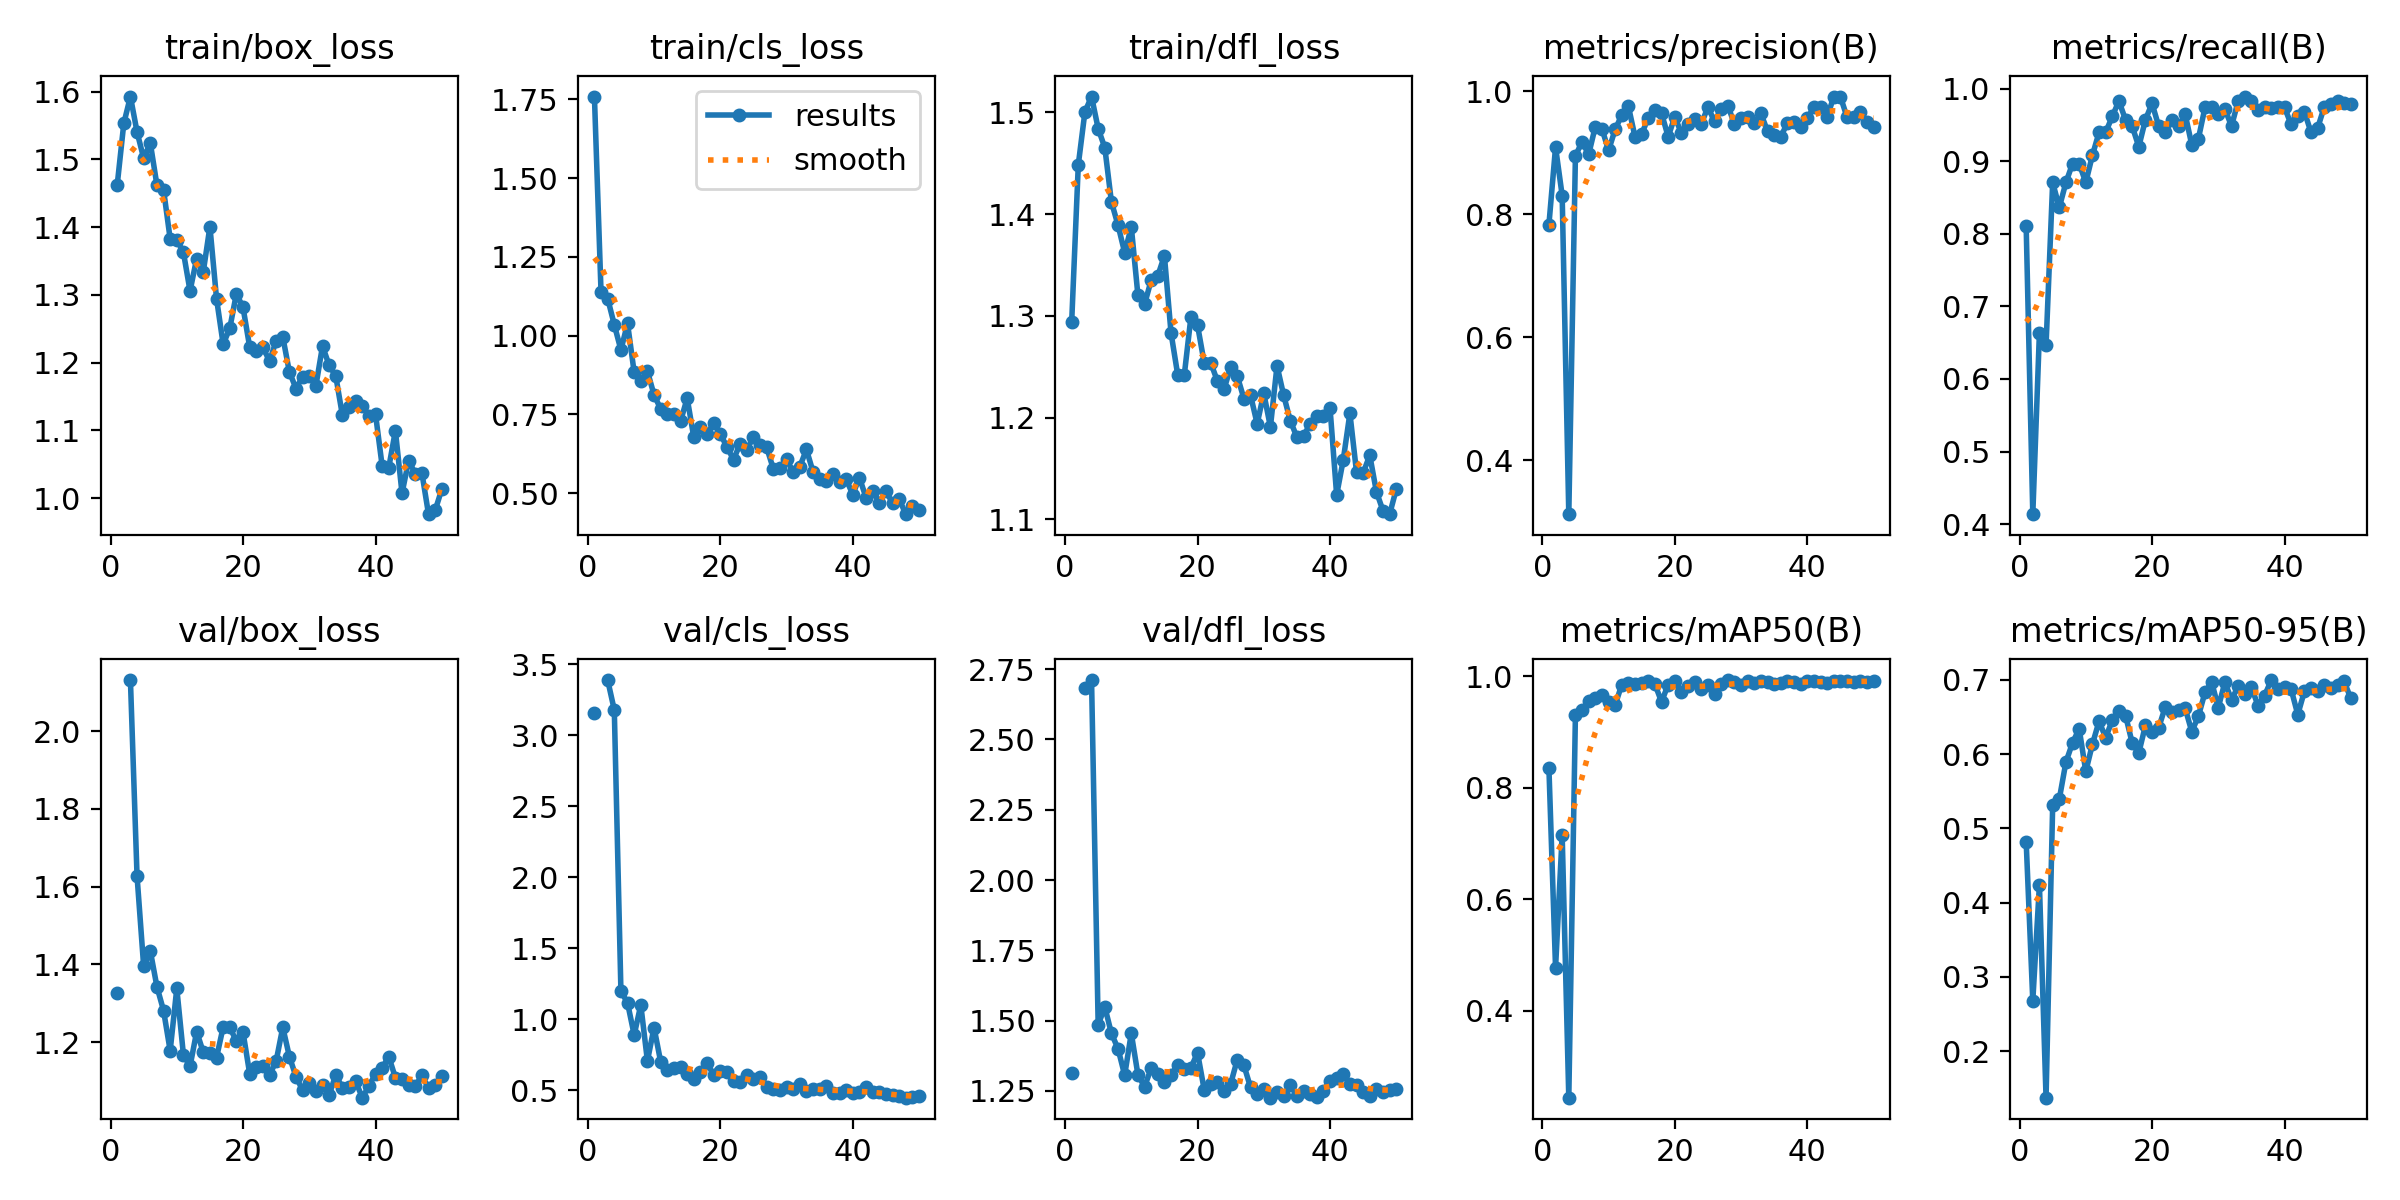

In [13]:
from IPython.display import Image
Image('/content/runs/detect/car_detection_colab/results.png')


image 1/1 /content/data/images/val/vid_4_11420.jpg: 384x640 1 car, 25.1ms
Speed: 2.3ms preprocess, 25.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


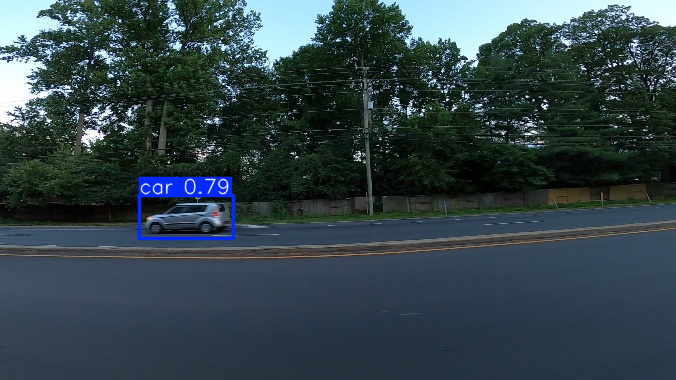

In [19]:
from matplotlib import pyplot as plt

# Load an image
img_path = '/content/data/images/val/vid_4_11420.jpg'  # pick any image
results = model(img_path)

# results.show() will display the image with bounding boxes
results[0].show()



image 1/1 /content/data/images/val/vid_4_12160.jpg: 384x640 3 cars, 25.0ms
Speed: 1.7ms preprocess, 25.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


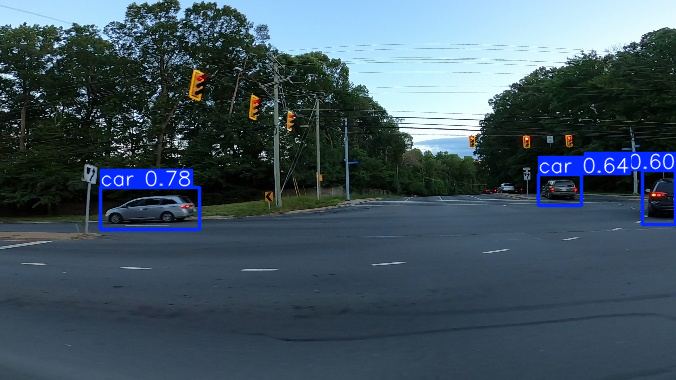

In [20]:
from matplotlib import pyplot as plt

# Load an image
img_path = '/content/data/images/val/vid_4_12160.jpg'  # pick any image
results = model(img_path)

# results.show() will display the image with bounding boxes
results[0].show()



image 1/1 /content/data/training_images/vid_4_10240.jpg: 384x640 (no detections), 25.2ms
Speed: 2.8ms preprocess, 25.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


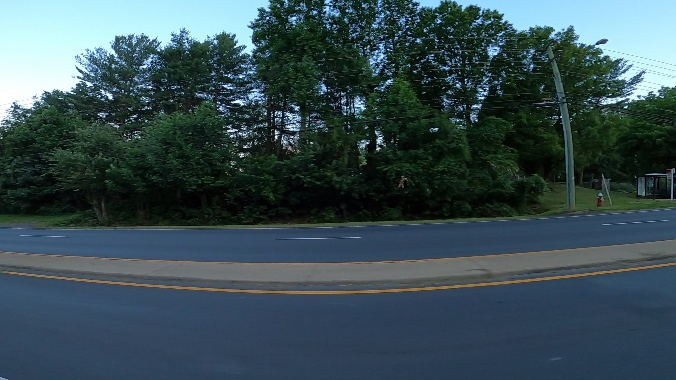


image 1/1 /content/data/training_images/vid_4_4380.jpg: 384x640 (no detections), 25.0ms
Speed: 2.7ms preprocess, 25.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


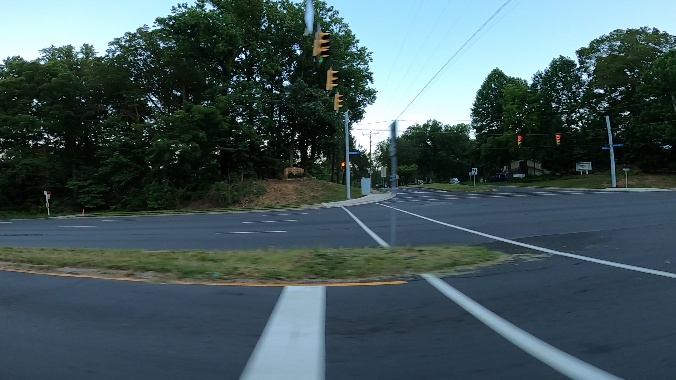


image 1/1 /content/data/training_images/vid_4_21040.jpg: 384x640 (no detections), 25.1ms
Speed: 2.4ms preprocess, 25.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


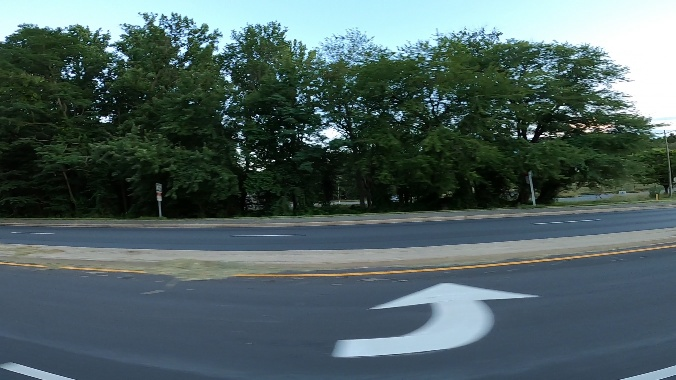


image 1/1 /content/data/training_images/vid_4_3620.jpg: 384x640 (no detections), 25.1ms
Speed: 2.6ms preprocess, 25.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


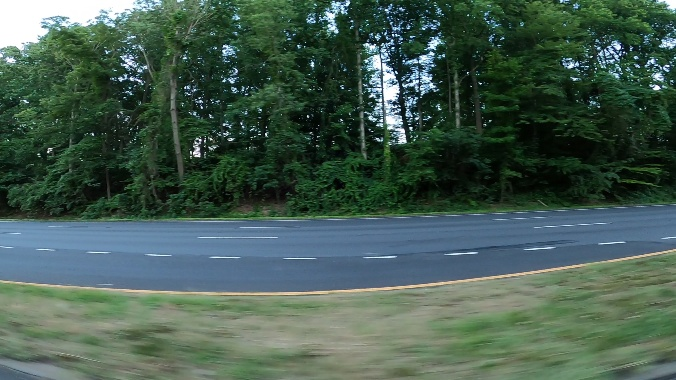


image 1/1 /content/data/training_images/vid_4_6440.jpg: 384x640 3 cars, 25.0ms
Speed: 2.7ms preprocess, 25.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


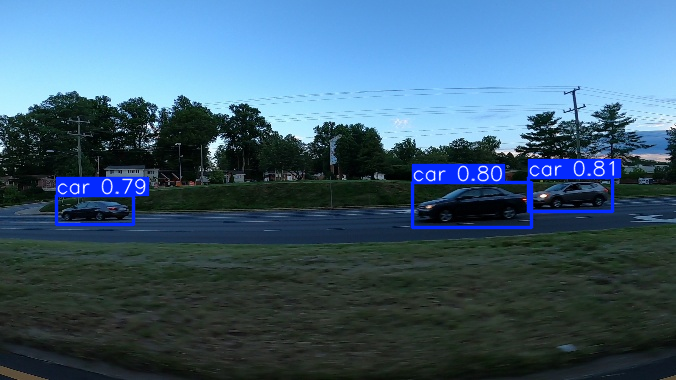

In [16]:
for img_path in val_images[:5]:  # visualize first 5 val images
    results = model(img_path)     # returns a list of Results
    results[0].show()             # show the first (and usually only) result
